In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyautogui
import urllib.parse
import time
import string
import pyperclip
from bs4 import BeautifulSoup
from email import policy
from email.parser import BytesParser
import psycopg2
import requests
import json
import pickle
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import nltk
from gensim.models import LdaModel, CoherenceModel
import gensim.corpora as cor
from nltk.corpus import words
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV,KFold,train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to C:\Users\Xiang
[nltk_data]     Gao\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Xiang
[nltk_data]     Gao\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Xiang
[nltk_data]     Gao\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Xiang
[nltk_data]     Gao\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 1.Data Collection

(1). Download LinkedIn Search Results Webpages

In [2]:
# Create an automatic process to download the job search pages in Linkedin
def auto_download_search(url,file_name):
    pyautogui.hotkey('ctrl', '2') # switch Google Chrome tabs
    time.sleep(1)
    
    pyautogui.click(207,55) # click the browser's address bar.
    time.sleep(0.5)
    
    pyautogui.hotkey('ctrl', 'a') # select all content in the address bar.
    pyperclip.copy(url) # copy the url
    time.sleep(0.5)
    
    pyautogui.hotkey('ctrl', 'v') # paste the url
    time.sleep(0.5)
    
    pyautogui.hotkey('enter') # access the url
    time.sleep(10)
    
    pyautogui.click(882,1023)
    pyautogui.mouseDown() # scroll down the page to look through all job posts
    time.sleep(10)
    pyautogui.mouseUp()# release the left mouse button
    
    pyautogui.hotkey('ctrl', 's') # save the page to local path
    time.sleep(2)
    pyperclip.copy(file_name) # copy the file name
    pyautogui.hotkey('ctrl', 'v') # paste the file name
    time.sleep(2)
    pyautogui.hotkey('enter') # save the page with given name

In [3]:
# create a process to look through all the pages of search results
def search_page_download(num = 0):
    for i in range(0,1000,25):
        url = f"https://www.linkedin.com/jobs/search/?currentJobId=3733476715&f_SB2=1&f_TPR=r2592000&geoId=103644278&keywords=data%20scientist&location=United%20States&origin=JOB_SEARCH_PAGE_JOB_FILTER&refresh=true&sortBy=R&spellCorrectionEnabled=true&start={i}"
        file_name = f"data_science_job_{num + int(i/25)}.mhtml"
        auto_download_search(url, file_name)

In [4]:
# download all pages to collect 1000 job posts related to data science
search_page_download(40)

(2). Extract Individual Job Post URLs from LinkedIn Search Results

In [5]:
# extract urls of job posts from all the pages
def job_url(file_path):
    urls = []
    # Open the MHTML file in binary mode and parse it
    with open(file_path, 'rb') as file:
        msg = BytesParser(policy=policy.default).parse(file)

    # Decode the HTML part correctly
    html_part = None
    for part in msg.walk():
        content_type = part.get_content_type()
        if content_type == 'text/html':
            html_part = part.get_payload(decode=True)
            break
    
    # parse the HTML
    charset = 'utf-8'
    decoded_html = html_part.decode(charset)
    soup = BeautifulSoup(decoded_html, 'html.parser')
    jobs = soup.find(class_ = "scaffold-layout__list-container")
    job_info = jobs.find_all(class_ = "disabled ember-view job-card-container__link job-card-list__title")
    # extract the url for each job post
    for i in job_info:
        url = i['href']
        urls.append(url)
    return urls

In [6]:
job_urls = {}
i = 0
path = "D:/Study Abroad/course/DSCI441/project/webpages"

# get the urls of all job posts from the local job pages
for root, dirs, files in os.walk(path):
    for file in files:
        file_path = os.path.join(root, file)
        urls = job_url(file_path)
        for url in urls:
            job_urls[i] = {}
            job_urls[i]["url"] = url
            job_urls[i]["status"] = 0
            i += 1

(3). Download Job Post Details Webpages

In [7]:
# manually login the linkedin website
driver = webdriver.Chrome()
driver.get("https://www.linkedin.com/home")

# wait enough time to log in manually
time.sleep(20)  

# save the cookies to a file after login
pickle.dump(driver.get_cookies(), open("D:/Study Abroad/course/DSCI441/project/cookies.pkl", "wb"))

driver.quit()

In [8]:
# use selenium webdriver to iterate all the job pages
# set the options
options = webdriver.ChromeOptions()
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

# load the previously saved cookies
cookies = pickle.load(open("D:/Study Abroad/course/DSCI441/project/cookies.pkl", "rb"))

# iterate all job post pages and download them to local path
for i in range(0,1000):
    index = i
    value = job_urls[index]
    
    # open a new driver after iterating the job post pages for 20 times in order to save memory
    if index % 20 == 0:
        driver = webdriver.Chrome(options=options)
        driver.get("https://www.linkedin.com/home")
        time.sleep(4)
        
        # load the cookies to the driver
        for cookie in cookies:
            driver.add_cookie(cookie)
        time.sleep(1)
    
    # get the url for job post
    url = value["url"]
    driver.get(url)
    
    time.sleep(5)
    
    # use the aria-label to locate the button
    button_aria_label = "Click to see more description"
    try:
        # Wait up to 10 seconds for the button to be clickable
        button = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, f"//button[@aria-label='{button_aria_label}']")))
        # click the button "Show More" to show the entire job description
        button.click()
        
        time.sleep(2) # wait up for all information displayed
        
    except Exception as e:
        break # if failed, jump to the next iteration
    
    pyautogui.hotkey('ctrl', 's') # save the page to local path
    time.sleep(2)
    
    file_name = "data_scientist_job_post_" + str(index)
    pyperclip.copy(file_name) # copy the file name
    
    pyautogui.hotkey('ctrl', 'v') # paste the file name
    time.sleep(2)
    
    if index % 20 == 0:
        pyautogui.hotkey('tab')  # select the save type
        time.sleep(1)

        pyautogui.hotkey('down')
        time.sleep(1)

        pyautogui.hotkey('up')  # save file to mhtml
        time.sleep(1)

        pyautogui.hotkey('enter') # confirm the file tyep
        time.sleep(1)
    
    pyautogui.hotkey('enter') # save
    time.sleep(np.random.randint(1,4)) # wait for random time
    
    if index % 20 == 19:
        driver.quit()

(4). Extract Key Information from Job Posting Webpages

In [9]:
# categorize all job_type, remote, and experience
JOB_TYPE = ["Full-time","Part-time","Contract","Temporary","Internship","Other"]
REMOTE_TYPE = ["On-site","Remote","Hybrid"]
EXPERIENCE_TYPE = ["Internship","Entry level","Associate","Mid-Senior level","Director","Executive"]

In [10]:
# define functions to extract job_type, remote, and experience information
def extract_info(info, options):
    for i in options:
        if i in info:
            return i
    return None

In [11]:
# create variables to store the details of all the jobs
indice = []
titles = []
companies = []
locations = []
job_types = []
remotes = []
experiences = []
salaries = []
company_sizes = []
fields = []
job_descriptions = []
skills_posted = []
skills_associated = []

In [12]:
# get the urls of all job posts from the local job pages
path = "D:/Study Abroad/course/DSCI441/project/jobposts"

for root, dirs, files in os.walk(path):
    for file in files:
        file_path = os.path.join(root, file)
        # Open the MHTML file in binary mode and parse it
        with open(file_path, 'rb') as file:
            msg = BytesParser(policy=policy.default).parse(file)

        # Decode the HTML part correctly
        html_part = None
        for part in msg.walk():
            content_type = part.get_content_type()
            if content_type == 'text/html':
                html_part = part.get_payload(decode=True)
                break

        # parse the HTML
        charset = 'utf-8'
        decoded_html = html_part.decode(charset)
        soup = BeautifulSoup(decoded_html, 'html.parser')
        
        # extract the index
        index = file_path.replace(".mhtml","").split("_")[-1]
        indice.append(index)
        
        # extract title
        title = soup.find(class_="t-24 t-bold job-details-jobs-unified-top-card__job-title").contents[0].strip()
        titles.append(title)
        
        # extract company and location
        company_location = soup.find(class_="job-details-jobs-unified-top-card__primary-description-without-tagline mb2").text.strip()
        company = company_location.split('·')[0].strip()
        location = company_location.split('·')[1].strip()
        companies.append(company)
        locations.append(location)
        
        # extract job_type, remote, experience, and salary
        salary_jobtype_Remote_Experience = soup.find(class_="job-details-jobs-unified-top-card__job-insight job-details-jobs-unified-top-card__job-insight--highlight").text
        job_type = extract_info(salary_jobtype_Remote_Experience,JOB_TYPE)
        remote = extract_info(salary_jobtype_Remote_Experience,REMOTE_TYPE)
        experience = extract_info(salary_jobtype_Remote_Experience,EXPERIENCE_TYPE)
        salary = salary_jobtype_Remote_Experience.strip().split('\n')[0]
        job_types.append(job_type)
        remotes.append(remote)
        experiences.append(experience)
        salaries.append(salary)
        
        # extract company size and field
        companysize_field = soup.find_all(class_ = "job-details-jobs-unified-top-card__job-insight")[1].text.split('·')
        company_size = companysize_field[0].strip()
        company_sizes.append(company_size)
        if len(companysize_field)>1: 
            field = companysize_field[1].strip() 
        else:
            field = None
        fields.append(field)
        
        # extract the job description
        job_description = soup.find(class_ = "jobs-box__html-content jobs-description-content__text t-14 t-normal jobs-description-content__text--stretch").text.strip()
        job_descriptions.append(job_description)

        # extract the associated skills and skills added by job posters
        skill_posted = [item.text for item in soup.find_all(class_="pt5")[1].find_all("a",class_="app-aware-link job-details-how-you-match__skills-item-subtitle t-14 overflow-hidden")]
        skill_associated = [item.text for item in soup.find_all(class_="pt5")[1].find_all("a",class_="app-aware-link job-details-how-you-match__skills-section-descriptive-skill t-14")]
        skills_posted.append(skill_posted)
        skills_associated.append(skill_associated)

In [13]:
df = pd.DataFrame((titles,companies,locations,job_types,remotes,experiences,salaries,company_sizes,fields,job_descriptions,skills_posted,skills_associated,indice)).T
df.columns=["Job_Title","Company_Name","Location","Job_Type","Remote","Experience_Level","Salary","Company_Size","Field","Job_Description","Posted_Skills","Associated_Skills","Files"]

(5). Store the information into postgres database

In [2]:
def insert_database(df,connection):
    cursor = connection.cursor()
    data = df.drop('Files',axis = 1).copy()
    data = data.fillna("Unknown")
    # insert into database
    try:
        for fields in data.values:
            insert_query = "INSERT INTO t_ds_job_info"
            insert_columns = '("' + '","'.join(data.columns) + '")'
            insert_values = "(" 
            for field in fields:
                insert_values += "'" + str(field).replace("'","").replace('"','') + "',"
            insert_values = insert_values[:-1]
            insert_values +=  ")"
            insert_query = insert_query + insert_columns + " VALUES " + insert_values
            cursor.execute(insert_query)
            connection.commit()
    except:
        print(insert_query)

    # Close the connection
    cursor.close()
    connection.close()
    
# a function to extract data from database
def query(SQL,connection):
    df = pd.read_sql(SQL,connection)
    connection.close()
    
    return df

In [2]:
# define the connection
connection = psycopg2.connect(
    dbname="postgres",
    user="postgres",
    password="postgres",
    host="localhost",
    port="5432"
)
# save the information
insert_database(df,connection)

In [3]:
connection = psycopg2.connect(
    dbname="postgres",
    user="postgres",
    password="postgres",
    host="localhost",
    port="5432"
)
# save the information
SQL = 'select distinct "Job_Title","Company_Name" ,"Location","Job_Type","Remote","Experience_Level","Salary","Company_Size" ,"Field" ,"Job_Description" ,"Posted_Skills","Associated_Skills" from t_ds_job_info'
df = query(SQL,connection)

In [4]:
df

,Job_Title,Company_Name,Location,Job_Type,Remote,Experience_Level,Salary,Company_Size,Field,Job_Description,Posted_Skills,Associated_Skills
0,"Data Scientist II, Amazon Business Ops Analytics",Amazon,"Arlington, VA",Full-time,Unknown,Mid-Senior level,"$111,600/yr - $212,800/yr","10,001+ employees",Software Development,About the job\n \n \nDescriptionWe ...,[],"[Machine Learning · Extract, Transform, Load (..."
1,Data Scientist,CACI International Inc,"Denver, CO",Full-time,Unknown,Mid-Senior level,"$82,100/yr - $172,400/yr","10,001+ employees",IT Services and IT Consulting,About the job\n \n \nJob Category: ...,[],[Logistic Regression · Computer Vision · Machi...
2,Data Scientist with Security Clearance,ClearanceJobs,"Arlington, VA",Full-time,Hybrid,Mid-Senior level,"$155,000/yr",11-50 employees,Defense and Space Manufacturing,About the job\n \n \nAward Winning ...,[],[Data Mining · HTML · Data Analytics · SQL · P...
3,"Sr Data Scientist, ProServe GenAI - Open Reqs",Amazon Web Services (AWS),"Santa Clara, CA",Full-time,Unknown,Mid-Senior level,"$127,300/yr - $247,600/yr","10,001+ employees",IT Services and IT Consulting,About the job\n \n \nDescriptionAre...,[],[Machine Learning · Artificial Intelligence (A...
4,Data Scientist,Insight Global,"Seattle, WA",Contract,On-site,Mid-Senior level,$70/hr - $80/hr,"1,001-5,000 employees",Staffing and Recruiting,About the job\n \n \nSr. Data Scien...,[],[Python (Programming Language) · Applied Machi...
...,...,...,...,...,...,...,...,...,...,...,...,...
616,Mission Solution SAFe Shared Services- Data Sc...,CACI International Inc,"Aurora, CO",Full-time,On-site,Mid-Senior level,"$104,200/yr - $229,200/yr","10,001+ employees",IT Services and IT Consulting,About the job\n \n \nJob Category: ...,[],[R (Programming Language) · Big Data Analytics...
617,Data Scientist,Booz Allen Hamilton,"Huntsville, AL",Full-time,Unknown,Unknown,"$73,000/yr - $166,000/yr","10,001+ employees",IT Services and IT Consulting,About the job\n \n \nJob Number: R0...,[],[Data Mining · Analytics · Data Analytics · Pa...
618,"Data Scientist, Analytics - Tiktok",TikTok,"San Jose, CA",Full-time,Unknown,Unknown,"$144,000/yr - $240,000/yr","10,001+ employees",Entertainment Providers,About the job\n \n \nResponsibiliti...,[],[Data Visualization · Natural Language Process...
619,"Data Scientist, Mid",Booz Allen Hamilton,"Smith, IN",Full-time,Unknown,Unknown,"$73,000/yr - $166,000/yr","10,001+ employees",IT Services and IT Consulting,About the job\n \n \nJob Number: R0...,[],[Python (Programming Language) · Analytics · D...


# 2.Data Processing

(1). Reformat numerical and categorical features

In [5]:
# define function to extract state from location
def location_to_state(value):
    area_state_dict = {"United States":"Unknown",
                 "Los Angeles Metropolitan Area": "CA",
                 "Greater Seattle Area": "WA",
                 "New York City Metropolitan Area": "NY",
                 "Greater Minneapolis-St. Paul Area": "MN",
                 "San Francisco Bay Area": "CA",
                 "Miami-Fort Lauderdale Area": "FL",
                 "Atlanta Metropolitan Area": "GA",
                 "Washington DC-Baltimore Area": "DC",
                 "Charlotte Metro": "NC",
                 "Greater Phoenix Area": "AZ",
                 "Dallas-Fort Worth Metroplex": "TX",
                 "Greater Richmond Region": "VA" ,
                 "San Diego Metropolitan Area": "CA",
                 "Greater Boston": "MA",
                 "Oregon Metropolitan Area":"OR",
                 'Alabama': 'AL',
                 'Alaska': 'AK',
                 'Arizona': 'AZ',
                 'Arkansas': 'AR',
                 'California': 'CA',
                 'Colorado': 'CO',
                 'Connecticut': 'CT',
                 'Delaware': 'DE',
                 'Florida': 'FL',
                 'Georgia': 'GA',
                 'Hawaii': 'HI',
                 'Idaho': 'ID',
                 'Illinois': 'IL',
                 'Indiana': 'IN',
                 'Iowa': 'IA',
                 'Kansas': 'KS',
                 'Kentucky': 'KY',
                 'Louisiana': 'LA',
                 'Maine': 'ME',
                 'Maryland': 'MD',
                 'Massachusetts': 'MA',
                 'Michigan': 'MI',
                 'Minnesota': 'MN',
                 'Mississippi': 'MS',
                 'Missouri': 'MO',
                 'Montana': 'MT',
                 'Nebraska': 'NE',
                 'Nevada': 'NV',
                 'New Hampshire': 'NH',
                 'New Jersey': 'NJ',
                 'New Mexico': 'NM',
                 'New York': 'NY',
                 'North Carolina': 'NC',
                 'North Dakota': 'ND',
                 'Ohio': 'OH',
                 'Oklahoma': 'OK',
                 'Oregon': 'OR',
                 'Pennsylvania': 'PA',
                 'Rhode Island': 'RI',
                 'South Carolina': 'SC',
                 'South Dakota': 'SD',
                 'Tennessee': 'TN',
                 'Texas': 'TX',
                 'Utah': 'UT',
                 'Vermont': 'VT',
                 'Virginia': 'VA',
                 'Washington': 'WA',
                 'West Virginia': 'WV',
                 'Wisconsin': 'WI',
                 'Wyoming': 'WY'}
    
    if "," not in value:
        state = area_state_dict.get(value.strip(),"Unknown")
    elif len(value.split(",")[1].strip())>2 and value.split(",")[1].strip()!="United States":
        state = area_state_dict.get(value.split(',')[1].strip())
    elif len(value.split(",")[1].strip())>2 and value.split(",")[1].strip()=="United States":
        state = area_state_dict.get(value.split(',')[0].strip(),"Unknown")
    else:
        state = value.split(',')[1].strip()
    
    return state

# define function to extract the salary range
def salary_to_annual_salary_range(value):
    if "-" not in value and "/hr" in value:
        value = value.replace("/hr","")
        value = value.replace("$","") 
        value = value.replace(",","")
        upper = float(value) * 40 * 52
        lower = float(value) * 40 * 52
        
    elif "-" not in value and "/yr" in value:
        value = value.replace("/yr","")
        value = value.replace("$","") 
        value = value.replace(",","")
        value = value.replace("Up to ","")
        upper = float(value)
        lower = float(value)
    
    elif "-" in value and "/hr" in value:
        value = value.replace("/hr","")
        value = value.replace("$","") 
        value = value.replace(",","")
        upper = float(value.split("-")[0].strip())  * 40 * 52
        lower = float(value.split("-")[1].strip())  * 40 * 52
    
    elif "-" in value and "/month" in value:
        value = value.replace("/month","")
        value = value.replace("$","") 
        value = value.replace(",","")
        upper = float(value.split("-")[0].strip()) * 12
        lower = float(value.split("-")[1].strip()) * 12

    elif "-" in value and "/yr" in value:
        value = value.replace("/yr","")
        value = value.replace("$","") 
        value = value.replace(",","")
        upper = float(value.split("-")[0].strip())
        lower = float(value.split("-")[1].split("+")[0].strip())
    return upper, lower

# define function to quantize the avg company size 
def avg_company_size(value):
    dict_company_size = {'10,001+ employees':  20000,
                         '5,001-10,000 employees': 7500,
                         '1,001-5,000 employees': 3000,
                         '501-1,000 employees': 750,
                         '201-500 employees': 350,
                         '51-200 employees': 125,
                         '11-50 employees' : 30,
                         '1-10 employees' : 5                       
                        }
    company_size = dict_company_size.get(value,0)
    return company_size

In [6]:
# extract the state information
# drop the city and area information since it is too detailed and may cause overfitting after one-hot encoding
df["State"] = df["Location"].apply(location_to_state)

# extract the range of salary
df["Salary_Lower"] = df["Salary"].apply(salary_to_annual_salary_range).apply(lambda x:x[0])
df["Salary_Upper"] = df["Salary"].apply(salary_to_annual_salary_range).apply(lambda x:x[1])

# quantize the Company_Size using the avg value
df['Company_Size'] = df['Company_Size'].apply(avg_company_size)

(2). Handle text features

In [7]:
# define function to identify the english words included in the job title
def words_identification_title(value):
    punctuations = string.punctuation
    # Replace each punctuation mark with a space
    for p in punctuations:
        value = value.replace(p, " ")
    value = value.split(" ")
    value = [word.strip() for word in value]
    
    return value

# define function to identify the english words included in the job description
def words_identification_description(value):
    english_words = set(words.words())
    tokens = word_tokenize(value)
    identified_words = [token.strip() for token in tokens if token.lower() in english_words]
    return identified_words

# define function to identify the skills in the Posted_Skills
def posted_skillset(value):
    value = value.replace('[','')
    value = value.replace(']','')
    value = value.replace(', and',',')
    skillset = value.split(",")
    skillset = [skill.strip() for skill in skillset]
    if skillset == ['']:
        skillset = []
        
    return skillset

# define function to identify the skills in the Associated_Skills
def associated_skillset(value):
    value = value.replace('[','')
    value = value.replace(']','')
    skillset = value.split('·')
    skillset = [skill.strip() for skill in skillset]
    if skillset == ['']:
        skillset = []
    return skillset

In [8]:
# extract words from job title
df['Job_Title_Words'] = df['Job_Title'].apply(words_identification_title)

# extract words from job description
df['Job_Description_Words'] = df['Job_Description'].apply(words_identification_description)

# extract posted skills
df['Posted_Skills'] = df['Posted_Skills'].apply(posted_skillset)

# extract associated skills
df['Associated_Skills'] = df['Associated_Skills'].apply(associated_skillset)

In [9]:
df = df[['Job_Title_Words','Company_Name','State','Job_Type','Remote','Experience_Level','Company_Size','Field', 'Job_Description', 'Job_Description_Words','Posted_Skills','Associated_Skills' ,'Salary_Lower','Salary_Upper']]
df

,Job_Title_Words,Company_Name,State,Job_Type,Remote,Experience_Level,Company_Size,Field,Job_Description,Job_Description_Words,Posted_Skills,Associated_Skills,Salary_Lower,Salary_Upper
0,"[Data, Scientist, II, , Amazon, Business, Ops,...",Amazon,VA,Full-time,Unknown,Mid-Senior level,20000,Software Development,About the job\n \n \nDescriptionWe ...,"[About, the, job, are, seeking, a, Data, Scien...",[],"[Machine Learning, Extract, Transform, Load (E...",111600.0,212800.0
1,"[Data, Scientist]",CACI International Inc,CO,Full-time,Unknown,Mid-Senior level,20000,IT Services and IT Consulting,About the job\n \n \nJob Category: ...,"[About, the, job, Job, Category, Type, Full, C...",[],"[Logistic Regression, Computer Vision, Machine...",82100.0,172400.0
2,"[Data, Scientist, with, Security, Clearance]",ClearanceJobs,VA,Full-time,Hybrid,Mid-Senior level,30,Defense and Space Manufacturing,About the job\n \n \nAward Winning ...,"[About, the, job, Award, Winning, Business, An...",[],"[Data Mining, HTML, Data Analytics, SQL, Postg...",155000.0,155000.0
3,"[Sr, Data, Scientist, , ProServe, GenAI, , , O...",Amazon Web Services (AWS),CA,Full-time,Unknown,Mid-Senior level,20000,IT Services and IT Consulting,About the job\n \n \nDescriptionAre...,"[About, the, job, you, looking, to, work, at, ...",[],"[Machine Learning, Artificial Intelligence (AI...",127300.0,247600.0
4,"[Data, Scientist]",Insight Global,WA,Contract,On-site,Mid-Senior level,3000,Staffing and Recruiting,About the job\n \n \nSr. Data Scien...,"[About, the, job, Data, Scientist, Hardware, a...",[],"[Python (Programming Language), Applied Machin...",145600.0,166400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616,"[Mission, Solution, SAFe, Shared, Services, , ...",CACI International Inc,CO,Full-time,On-site,Mid-Senior level,20000,IT Services and IT Consulting,About the job\n \n \nJob Category: ...,"[About, the, job, Job, Category, Type, Full, C...",[],"[R (Programming Language), Big Data Analytics,...",104200.0,229200.0
617,"[Data, Scientist]",Booz Allen Hamilton,AL,Full-time,Unknown,Unknown,20000,IT Services and IT Consulting,About the job\n \n \nJob Number: R0...,"[About, the, job, Job, Number, Opportunity, As...",[],"[Data Mining, Analytics, Data Analytics, Panda...",73000.0,166000.0
618,"[Data, Scientist, , Analytics, , , Tiktok]",TikTok,CA,Full-time,Unknown,Unknown,20000,Entertainment Providers,About the job\n \n \nResponsibiliti...,"[About, the, job, is, the, leading, destinatio...",[],"[Data Visualization, Natural Language Processi...",144000.0,240000.0
619,"[Data, Scientist, , Mid]",Booz Allen Hamilton,IN,Full-time,Unknown,Unknown,20000,IT Services and IT Consulting,About the job\n \n \nJob Number: R0...,"[About, the, job, Job, Number, Scientist, Oppo...",[],"[Python (Programming Language), Analytics, Dat...",73000.0,166000.0


# 3. EDA

(1). Distribution and Pattern of numerical and categorical features

In [10]:
# define function to draw bar plot
def bar_plot(df,feature,height):
    sns.set_theme(style="whitegrid")

    # initialize the matplotlib figure
    f, ax = plt.subplots(figsize=(6, height))

    # load the example car crash dataset
    data = df[feature].value_counts().reset_index()
    data.columns = [feature,"Count"]
    # plot the total crashes
    sns.set_color_codes("pastel")
    sns.barplot(x="Count", y = feature, data=data, color="b")
    sns.despine(left=True, bottom=True)

# define function to draw box plot
def box_plot(df,feature,target,width,height):
    sns.set_theme(style="whitegrid")

    # initialize the matplotlib figure
    f, ax = plt.subplots(figsize=(6, height))
    
    # Plot the orbital period with horizontal boxes
    order = df.groupby(feature)[target].mean().sort_values(ascending = False).index
    sns.boxplot(df, x = target, y = feature, width = width, palette="vlag", order = order)
    sns.despine(left=True, bottom=True)

California has way more data science jobs than other states. 
Most data science jobs are concentrated in the states along the East and West Coasts.


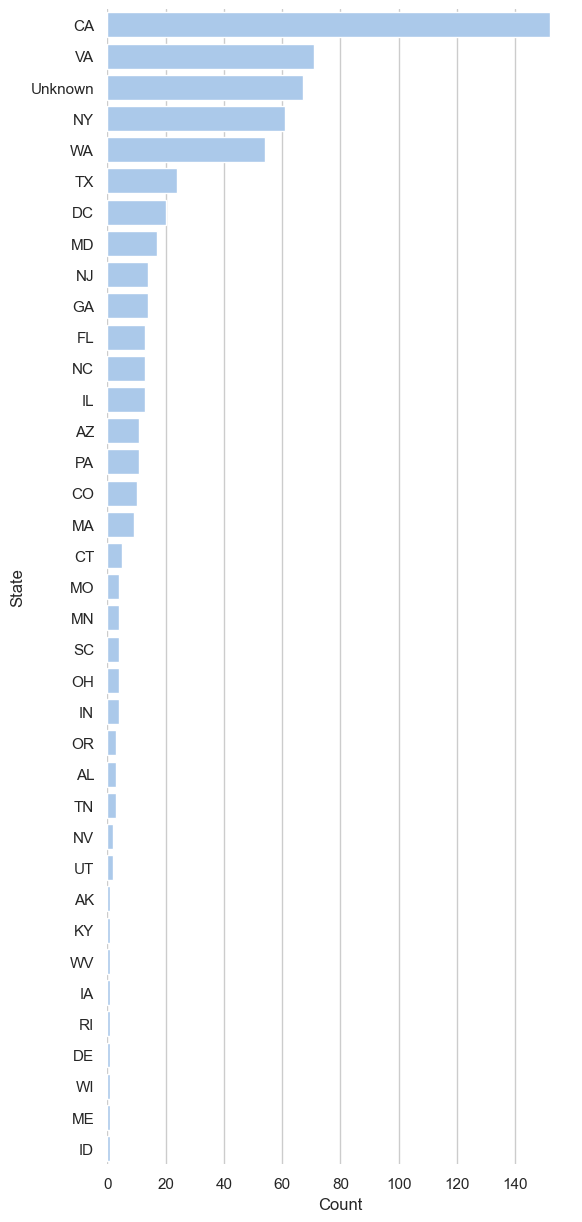

In [11]:
# Analysis of data science jobs with respect to State
bar_plot(df,"State",15)

# Observation
print("California has way more data science jobs than other states. ")
print("Most data science jobs are concentrated in the states along the East and West Coasts.")

Most data scientist roles are full-time. 
This might suggest that securing full-time positions as a data scientist might be easier than finding internships.


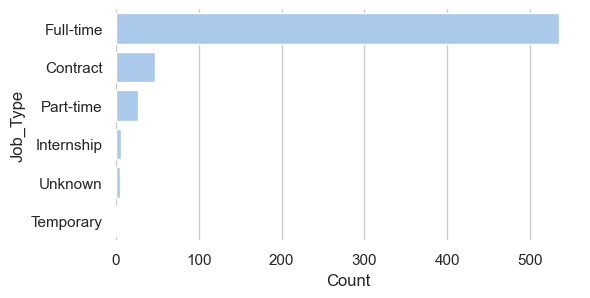

In [12]:
# Analysis of data science jobs with respect to Job_Type
bar_plot(df,"Job_Type",3)

# Observation
print("Most data scientist roles are full-time. ")
print("This might suggest that securing full-time positions as a data scientist might be easier than finding internships.")

A lot of data scientist positions allow for remote or hybrid working.
This might be part of why the data scientist job is getting more popular.


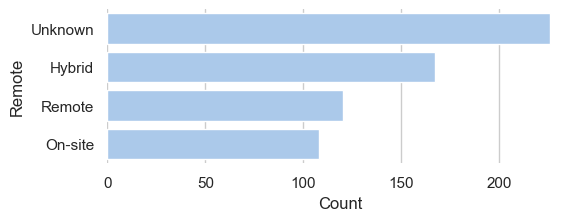

In [13]:
# Analysis of data science jobs with respect to Remote
bar_plot(df,"Remote",2)

# Observation
print('A lot of data scientist positions allow for remote or hybrid working.')
print('This might be part of why the data scientist job is getting more popular.')

The market demand is highest for data scientists at the Mid-Senior level.
This might indicate that beginners and new graduates will have difficulty in securing a position as a data scientist until they have accumulated enough experience.


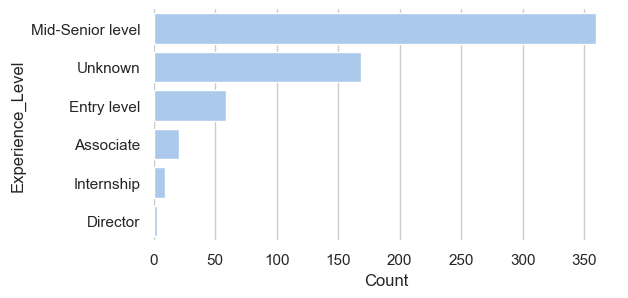

In [14]:
# Analysis of data science jobs with respect to Experience_Level
bar_plot(df,"Experience_Level",3)

# Observation
print("The market demand is highest for data scientists at the Mid-Senior level.")
print("This might indicate that beginners and new graduates will have difficulty in securing a position as a data scientist until they have accumulated enough experience.")

Large companies tend to have more data science jobs.
For small companies with limited data, an analyst could fulfill their primary needs rather than a data scientist.


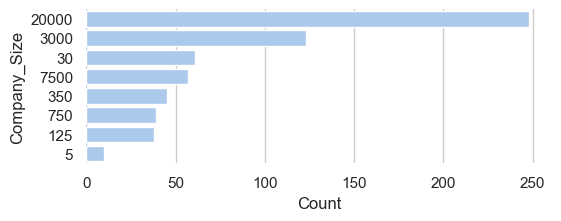

In [15]:
# Analysis of data science jobs with respect to Company_Size
bar_plot(df['Company_Size'].apply(str).reset_index(),"Company_Size",2)

# Observation
print("Large companies tend to have more data science jobs.")
print("For small companies with limited data, an analyst could fulfill their primary needs rather than a data scientist.")

The demand for data scientists is significantly higher in the IT industry compared to traditional sectors.
This might imply a great potential for data scientists to excel in traditional sectors.


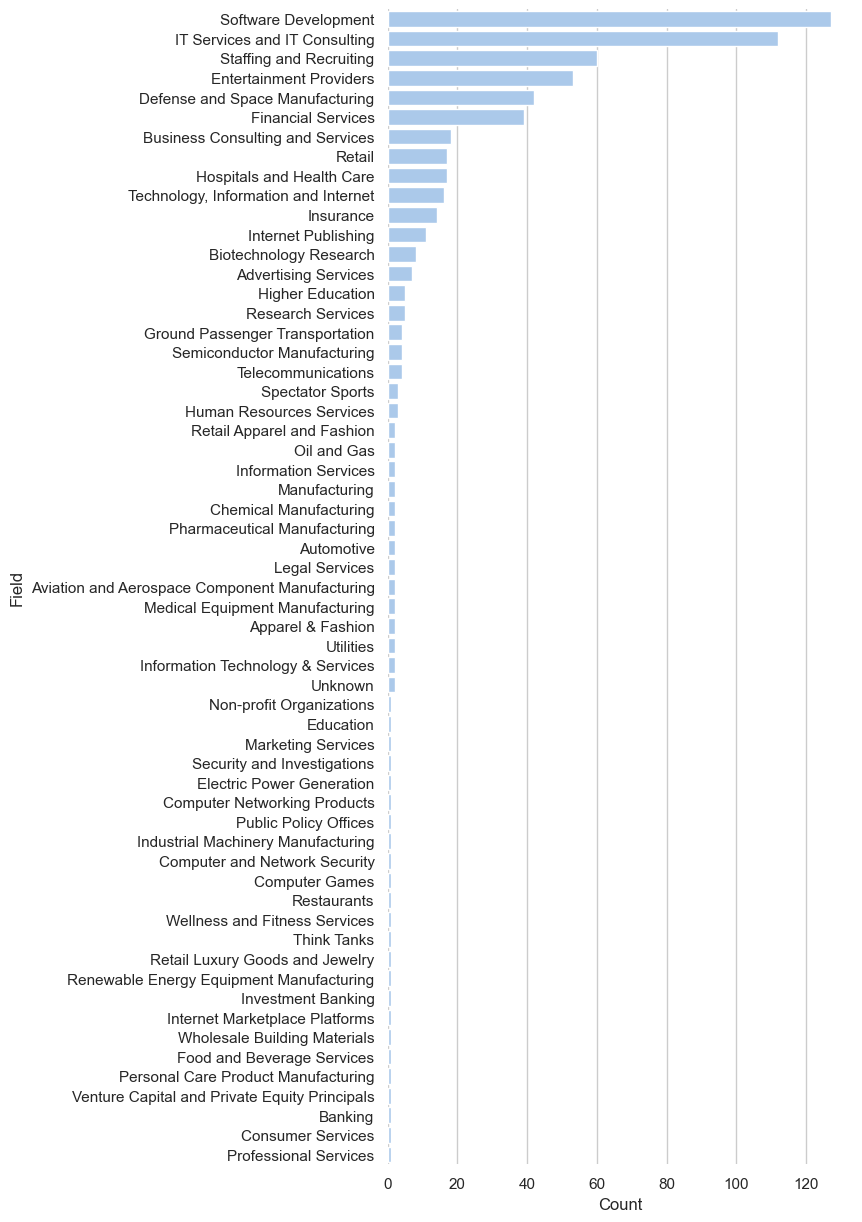

In [16]:
# Analysis of data science jobs with respect to Field
bar_plot(df,"Field",15)

# Observation
print('The demand for data scientists is significantly higher in the IT industry compared to traditional sectors.')
print('This might imply a great potential for data scientists to excel in traditional sectors.')

(2). Relationship between numerical and categorical features and the target

Nevada and Maine provide the highest salaries for data scientists, but this may stem from the limited number of positions available, potentially skewing the salary data.
Among states with more data science jobs, Washington and California provide the higher salaries.


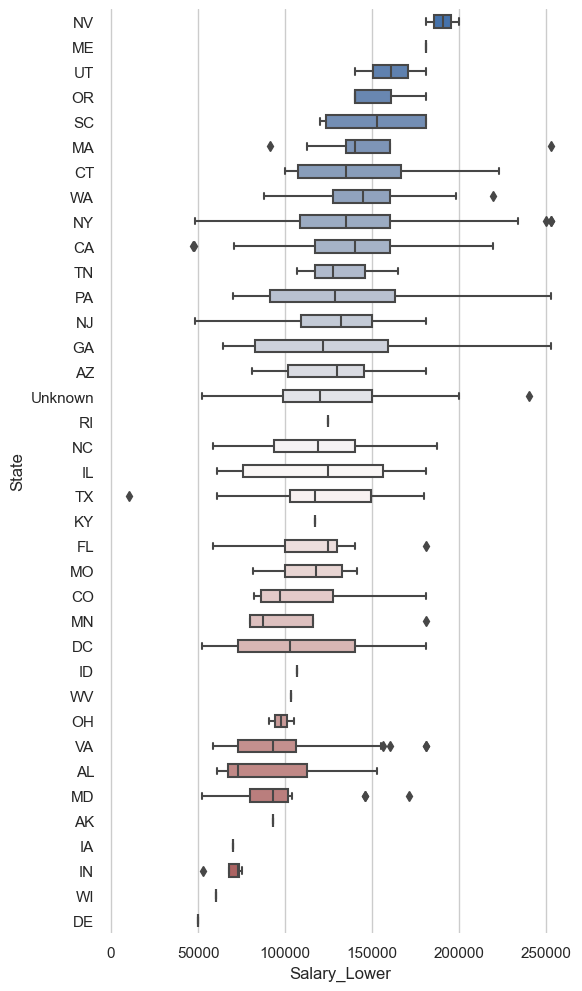

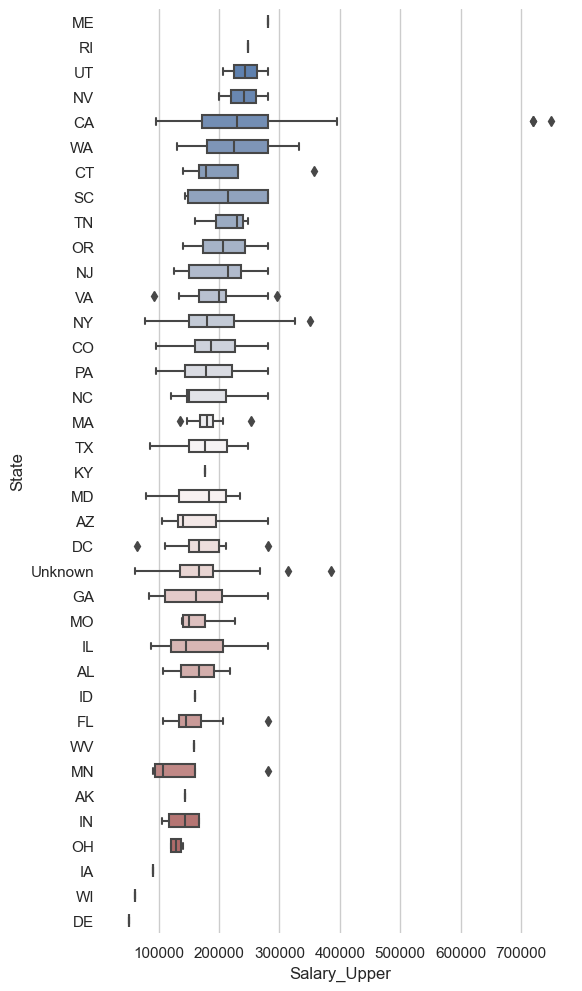

In [17]:
# Analysis of the State of data science jobs with respect to Salary
box_plot(df,"State","Salary_Lower",0.5,12)
box_plot(df,"State","Salary_Upper",0.5,12)

# Observation
print("Nevada and Maine provide the highest salaries for data scientists, but this may stem from the limited number of positions available, potentially skewing the salary data.")
print("Among states with more data science jobs, Washington and California provide the higher salaries.")

Full-time data scientist roles provide the highest salaries.
However, Contract and Part-time roles feature similar lower and upper salary ranges, respectively.
The salary disparities among these job types are relatively small.


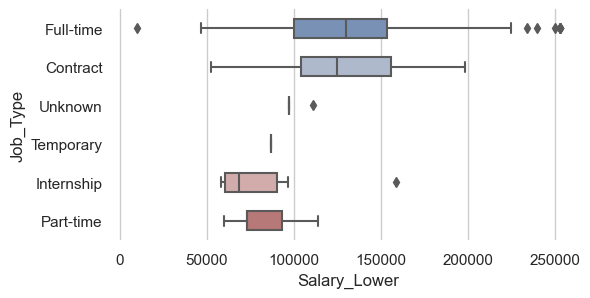

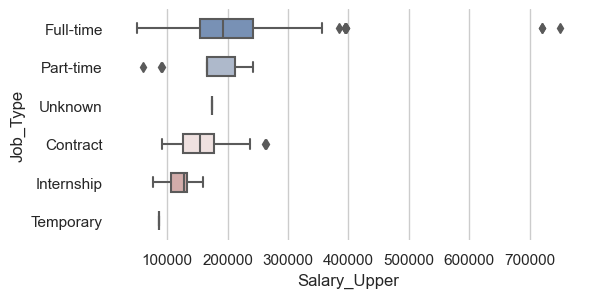

In [18]:
# Analysis of the Job_Type of data science jobs with respect to Salary
box_plot(df,"Job_Type","Salary_Lower",0.5,3)
box_plot(df,"Job_Type","Salary_Upper",0.5,3)

# Observation
print("Full-time data scientist roles provide the highest salaries.")
print("However, Contract and Part-time roles feature similar lower and upper salary ranges, respectively.")
print("The salary disparities among these job types are relatively small.")

Salaries for data scientist roles don't reveal significant disparities across various work arrangements.


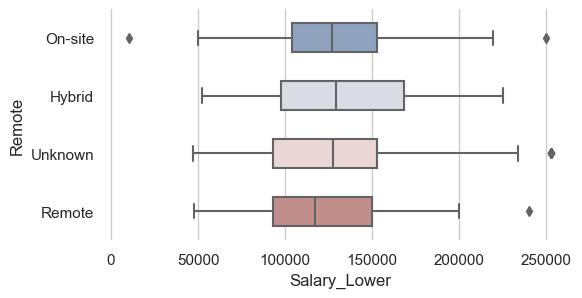

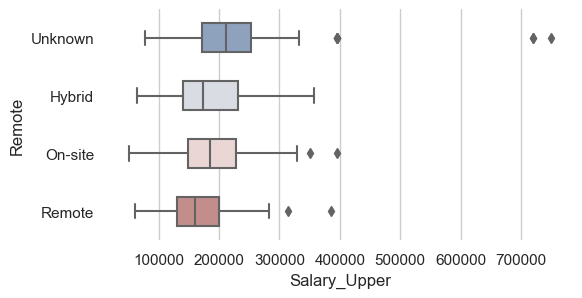

In [19]:
# Analysis of the Remote of data science jobs with respect to Salary
box_plot(df,"Remote","Salary_Lower",0.5,3)
box_plot(df,"Remote","Salary_Upper",0.5,3)

# Observation
print("Salaries for data scientist roles don't reveal significant disparities across various work arrangements.")

Apparently, salaries for data scientist roles rise in correlation with increasing experience level.


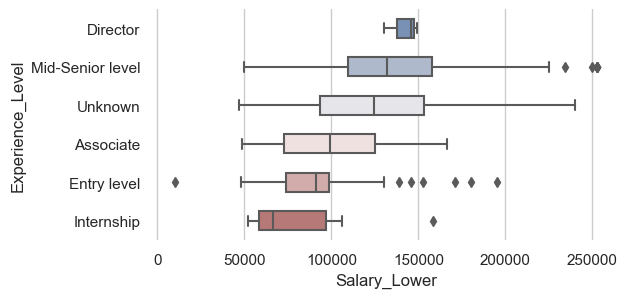

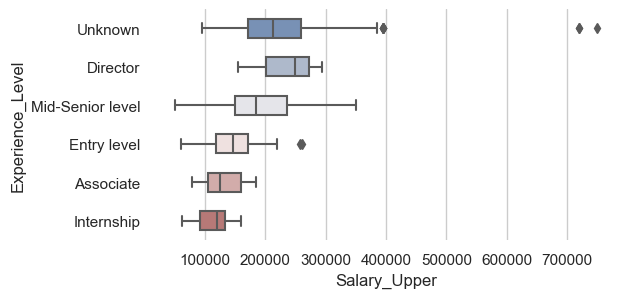

In [20]:
# Analysis of the Experience_Level of data science jobs with respect to Salary
box_plot(df,"Experience_Level","Salary_Lower",0.5,3)
box_plot(df,"Experience_Level","Salary_Upper",0.5,3)

# Observation
print("Apparently, salaries for data scientist roles rise in correlation with increasing experience level.")

Salaries for data scientist roles don't reveal significant disparities across various company sizes.


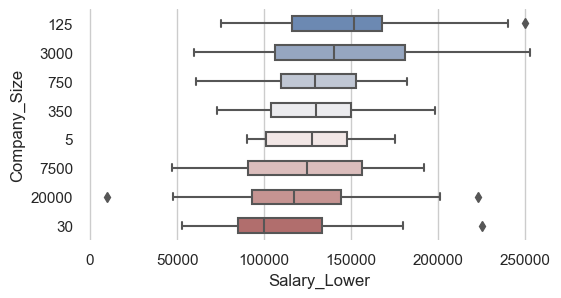

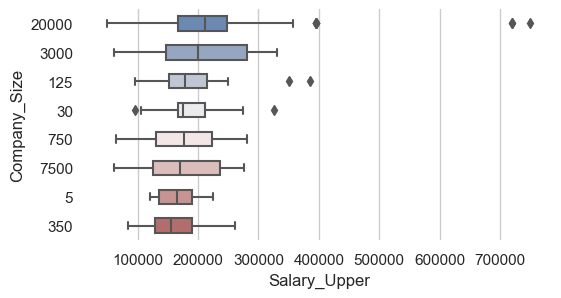

In [21]:
# Analysis of the Company_Size of data science jobs with respect to Salary
df_com = df.copy()
df_com['Company_Size'] = df_com['Company_Size'].apply(str)

box_plot(df_com,"Company_Size","Salary_Lower",0.5,3)
box_plot(df_com,"Company_Size","Salary_Upper",0.5,3)

# Observation
print("Salaries for data scientist roles don't reveal significant disparities across various company sizes.")

Automotive companies provides the highest salaries for data scientists, but this may stem from the limited number of positions available, potentially skewing the salary data.
Among industries with more data science jobs, Entertainment Providers and Software Development companies offer higher salaries.


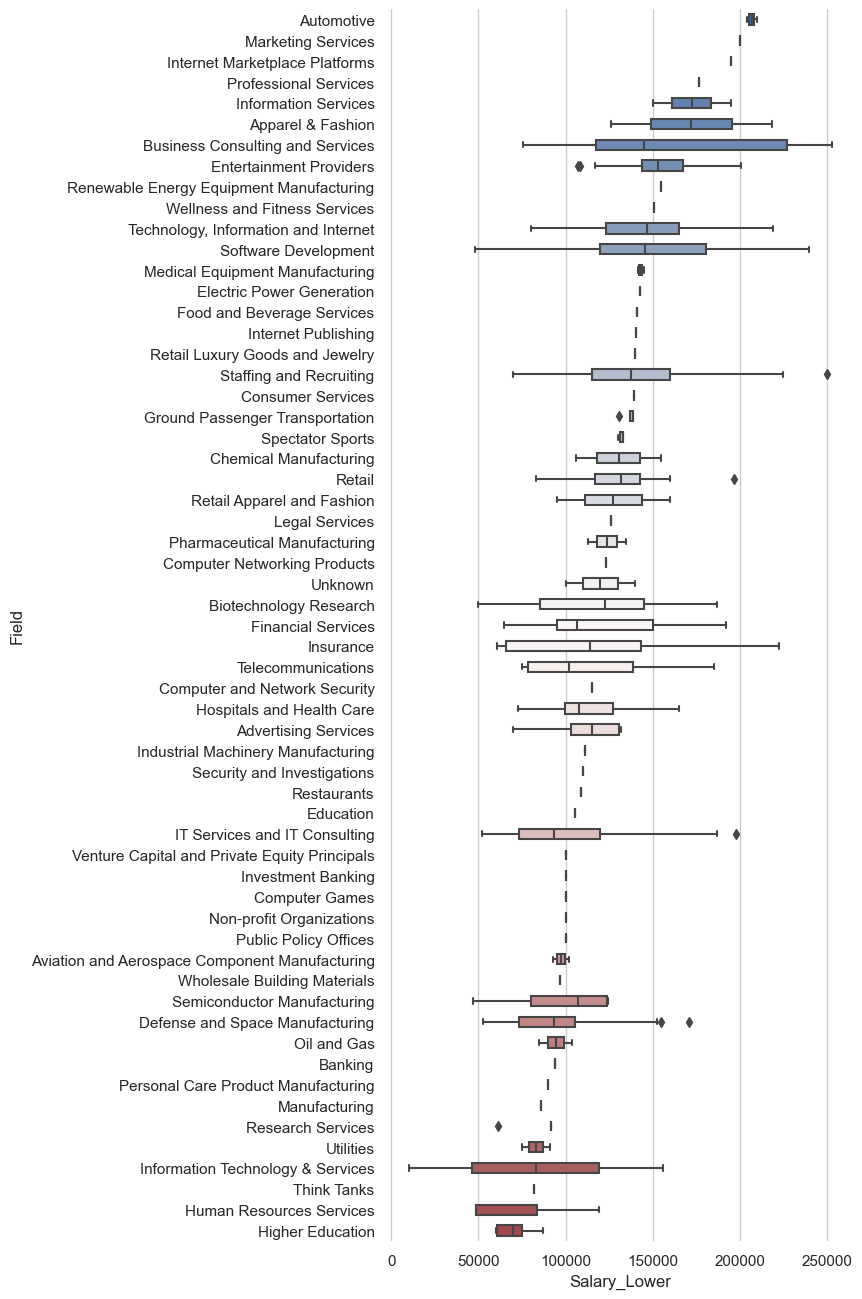

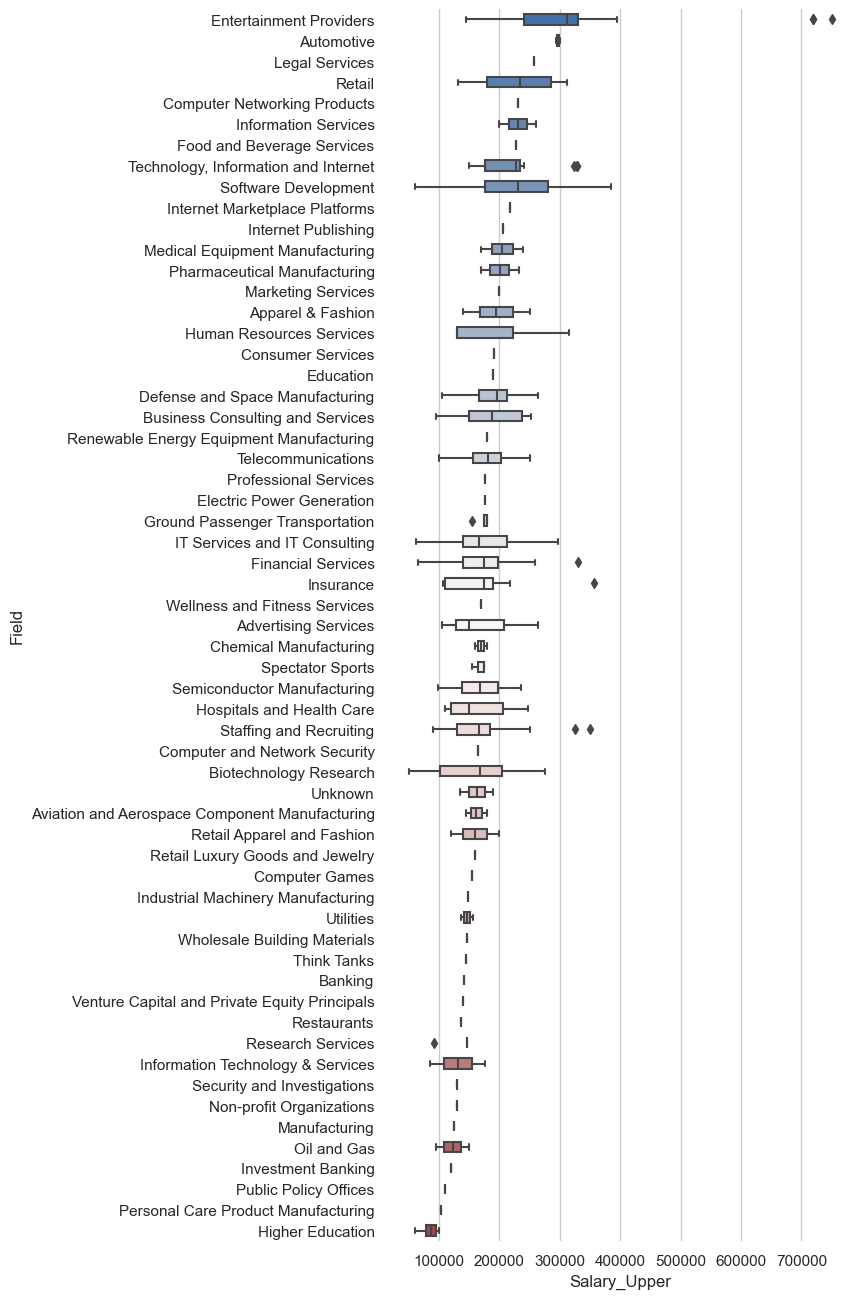

In [22]:
# Analysis of the Field of data science jobs with respect to Salary
box_plot(df_com,"Field","Salary_Lower",0.5,16)
box_plot(df_com,"Field","Salary_Upper",0.5,16)

# Observation
print("Automotive companies provides the highest salaries for data scientists, but this may stem from the limited number of positions available, potentially skewing the salary data.")
print("Among industries with more data science jobs, Entertainment Providers and Software Development companies offer higher salaries.")

(3). Distribution of keywords in the text features

In [541]:
# define function to extract words within text features
def word_extract(value, word_dict):
    for element in value:
        if type(element) != str:
            element = word_extract(element,word_dict)
        if element:
            word_dict[element] = word_dict.get(element,0) + 1

In [542]:
# Analysis of data science jobs with respect to words in job title
# extract words from job titles and count their occurrences.
job_title_word_dict = {}
word_extract(df['Job_Title_Words'].values,job_title_word_dict)

# output the most 50 frequenct words except data and scientist
df_job_title_word = pd.DataFrame({'Count':job_title_word_dict}).reset_index().sort_values('Count',ascending = False)
df_job_title_word.columns = ['Word','Count']
df_job_title_word_freq = df_job_title_word[2:52]
print(df_job_title_word_freq)
print()

# Observation
print("The frequent appearance of 'Senior', 'Principal', 'Sr', 'Lead', 'Staff', 'Mid' in job titles indicates that data scientist roles are mainly aimed at Mid-Senior level practitioners, consistent with our findings from the Experience_Level feature analysis.")
print("The frequent appearance of 'Clearance', 'Safety', and 'Security' indicates that many data science jobs necessitate Security Clearance, posing challenges for international students to seek employment in the field.")
print("The frequent appearance of 'Machine', 'Learning', 'Analytics', 'NLP', 'LLM', and 'AI' describes the key areas of application for data science within the industry")

            Word  Count
271       Senior    149
64     Clearance     40
270     Security     40
357         with     38
230    Principal     34
305       TikTok     29
326          and     28
285           Sr     24
178         Lead     23
286        Staff     22
180     Learning     21
201          Mid     21
33     Analytics     20
189      Machine     19
43           BCG     18
26           Ads     18
21   Acquisition     17
266      Science     17
233      Product     17
208          NLP     13
151           II     13
16            AI     13
39     Associate     12
105     Engineer     12
257         Risk     11
193    Marketing     11
249       Remote     11
341           of     10
113   Experience     10
314         USDS     10
274         Shop      9
323            X      9
118          Fed      9
165       Intern      9
358            –      9
261          SEO      9
149       Hybrid      9
134        GenAI      8
301         Tech      8
129          GBG      8
150            I

In [25]:
# Analysis of data science jobs with respect to words in job description
# extract words from job descriptions and count their occurrences.
job_description_word_dict = {}
word_extract(df['Job_Description_Words'].values,job_description_word_dict)

# output the most 50 frequenct words except data and scientist
df_job_description_word = pd.DataFrame({'Count':job_description_word_dict}).reset_index().sort_values('Count',ascending = False)
df_job_description_word.columns = ['Word','Count']
print(df_job_description_word[0:50])
print(df_job_description_word[50:100])
print(df_job_description_word[100:150])
print(df_job_description_word[150:200])
print(df_job_description_word[200:250])
print(df_job_description_word[250:300])
print(df_job_description_word[300:350])
print(df_job_description_word[350:400])
print()

# Observation:
print("Although the word list includes a lot of prepositions, we can still extract some insights from the dominant nouns and verbs.")
print("The frequent appearance of 'team', 'people', 'together', and 'collaborate/collaboration' might highlight the significance of teamwork as a crucial soft skill for data scientist candidates.")
print("The frequent appearance of 'experience', 'business', and 'product' might indicate might suggest the necessity of domain-specific knowledge alongside data science expertise for data scientists.")
print("The frequent appearance of 'health' ,'insurance', 'marketing', and 'drive' suggests the primary sectors where data science technologies are extensively applied.")
print("The frequent appearance of 'Python' and 'R' underscores their prevalence over other programming languages like Java, C++, and Matlab in data science.")

             Word  Count
2520          and  24851
6393           to  14472
6329          the  10801
5038           of   9850
2302            a   7771
4336           in   7012
6775         with   6126
3980          for   5755
3320         data   5191
5081           or   4490
4530           is   4010
5101          our   3852
2585           as   2941
6813          you   2890
2568          are   2592
5050           on   2514
6327         that   2416
6712           we   2355
3816   experience   2297
2509           an   2015
6785         work   1986
6764         will   1977
2702           be   1907
6815         your   1818
2242           We   1746
2619           at   1701
6288         team   1693
2843     business   1680
6356         this   1667
2849           by   1605
5781            s   1523
531          Data   1424
6331        their   1296
4616     learning   1285
5099        other   1187
2075          The   1178
4035         from   1109
2295          You   1059
5823      science   1035


In [26]:
# Analysis of data science jobs with respect to words in posted skill
# extract words from posted skills and count their occurrences.
posted_skill_word_dict = {}
word_extract(df['Posted_Skills'].values,posted_skill_word_dict)

# output the most 50 frequenct words except data and scientist
posted_skill_word = pd.DataFrame({'Count':posted_skill_word_dict}).reset_index().sort_values('Count',ascending = False)
posted_skill_word.columns = ['Word','Count']
posted_skill_word_freq = posted_skill_word[:50]
print(posted_skill_word_freq)
print()

# Observation:
print("The frequent appearance of 'NLP' ,'LLM', 'Generative AI' might indicate a shift towards more data science jobs specializing in the development of generative AI tools responsive to user prompts.")
print("The frequent appearance of 'Communication' and 'Presentations' highlights the importance of effective expression abilities for data scientists.")

                                         Word  Count
42                               Data Science     22
107         Natural Language Processing (NLP)     11
137             Python (Programming Language)     10
7                                   Analytics     10
29                           Computer Science     10
6                           Analytical Skills      9
83                Large Language Models (LLM)      9
28                              Communication      8
136                                   PyTorch      7
72                         Industry standards      7
158  Small and Medium-Sized Enterprises (SME)      6
181                                TensorFlow      6
131                        Project Management      6
149                                       SQL      6
36                             Data Analytics      6
175                          Systems Analysis      6
114                        Oral Communication      6
9                     Application Development 

In [27]:
# Analysis of data science jobs with respect to words in associated skill
# extract words from associated skills and count their occurrences.
associated_skill_word_dict = {}
word_extract(df['Associated_Skills'].values,associated_skill_word_dict)

# output the most 50 frequenct words except data and scientist
associated_skill_word = pd.DataFrame({'Count':associated_skill_word_dict}).reset_index().sort_values('Count',ascending = False)
associated_skill_word.columns = ['Word','Count']
associated_skill_word_freq = associated_skill_word[:50]
print(associated_skill_word_freq)
print()

# Observation:
print("The frequent appearance of 'Pattern Recognition' implies a greater emphasis on classification tasks in business contexts, as opposed to regression problems.")
print("The frequent appearance of 'TensorFlow' and 'Pytorch' points to a trend where more data science jobs focus on deep learning over conventional machine learning methods.")
print("The frequent appearance of 'Scala' and 'Apache Spark' suggests that many data science jobs require the use of parallel computing to handle large datasets.")

                                  Word  Count
174                       Data Science    502
145                     Data Analytics    232
432               Predictive Analytics    208
384  Natural Language Processing (NLP)    181
476      Python (Programming Language)    175
120                   Computer Science    167
182                 Data Visualization    157
417                Pattern Recognition    141
114                      Communication    122
578                         Statistics    115
144                      Data Analysis    112
33                           Analytics    105
529                                SQL    103
488           R (Programming Language)    100
354                        Mathematics     82
162                        Data Mining     81
340                   Machine Learning     80
153                   Data Engineering     79
46        Artificial Intelligence (AI)     75
196                      Deep Learning     75
567               Statistical Anal

# 4. Latent Dirichlet Allocation

(1). Preprocess the text data in the job descriptions

In [10]:
# copy job decription feature for LDA model training
df_LDA = df[['Job_Description']].copy()

def ldf_data_preprocess(text):
    # lowercase the text to ensure uniformity
    lowercased_text = text.lower()

    # split the text into individual words or tokens.
    tokens = word_tokenize(lowercased_text)

    # remove the stop words to focus on more significant words
    stop_words = set(stopwords.words('english'))
    tokens_filtered = [word for word in tokens if word not in stop_words]
    
    # remove the words that have less or equal to 3 letters
    stop_words = set(stopwords.words('english'))
    tokens_filtered = [word for word in tokens if len(word)>3]

    # removing punctuation and special characters
    tokens_filtered = [word for word in tokens_filtered if word.isalpha()]

    # reduce words to their root form
    lemmatizer = WordNetLemmatizer()
    tokens_lemmatized = [lemmatizer.lemmatize(word) for word in tokens_filtered]
    
    # remove some words that are not important(based on human experience and understanding)
    tokens = [word for word in tokens_filtered if word not in ('your','allen','booz','tiktok','meta','candidates')]
    return tokens

# Preprocess the text data in the job descriptions
df_LDA['Job_Description_tokens'] = df_LDA['Job_Description'].apply(ldf_data_preprocess)

In [11]:
df_LDA.head(5)

,Job_Description,Job_Description_tokens
0,About the job\n \n \nDescriptionWe ...,"[about, descriptionwe, seeking, data, scientis..."
1,About the job\n \n \nJob Category: ...,"[about, category, sciencetime, type, full, tim..."
2,About the job\n \n \nAward Winning ...,"[about, award, winning, business, analytics, f..."
3,About the job\n \n \nDescriptionAre...,"[about, descriptionare, looking, work, forefro..."
4,About the job\n \n \nSr. Data Scien...,"[about, data, scientist, telecom, hardware, ne..."


(2). Create a Bag of Words containing the number of times a word appears in the training set.

In [12]:
# create a Gensim dictionary
job_tokens = df_LDA['Job_Description_tokens']
dictionary = cor.Dictionary(job_tokens)

# Filter out extremes frequently and infrequently words to explore underlying distribution
# best practices and experience for no_below and no_above
dictionary.filter_extremes(no_below=5, no_above=0.6)

# convert the dictionary to a bag of words corpus
bow_corpus = [dictionary.doc2bow(doc) for doc in job_tokens]

In [13]:
# check the frequency of words within the corpura using the sample 100
bow_doc_100 = bow_corpus[100]

for i in range(len(bow_doc_100)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_100[i][0], dictionary[bow_doc_100[i][0]], bow_doc_100[i][1]))

Word 9 ("algorithms") appears 1 time.
Word 14 ("analytics") appears 9 time.
Word 19 ("applicants") appears 1 time.
Word 20 ("applied") appears 2 time.
Word 51 ("compensation") appears 1 time.
Word 59 ("customer") appears 2 time.
Word 60 ("customers") appears 1 time.
Word 64 ("defined") appears 2 time.
Word 66 ("delivery") appears 1 time.
Word 68 ("dependent") appears 4 time.
Word 75 ("directly") appears 1 time.
Word 87 ("employer") appears 2 time.
Word 91 ("environment") appears 1 time.
Word 110 ("gender") appears 1 time.
Word 121 ("identity") appears 3 time.
Word 133 ("into") appears 1 time.
Word 136 ("labor") appears 4 time.
Word 142 ("legally") appears 3 time.
Word 164 ("national") appears 1 time.
Word 167 ("needs") appears 1 time.
Word 168 ("network") appears 1 time.
Word 176 ("opportunities") appears 1 time.
Word 179 ("orientation") appears 1 time.
Word 180 ("origin") appears 1 time.
Word 192 ("person") appears 1 time.
Word 193 ("please") appears 1 time.
Word 195 ("potential") app

(3). Develop the LDA Model

In [32]:
# Set training parameters.
num_topics = 5 
passes = 15
random_state = 100

# Train the LDA model
lda_model = LdaModel(corpus = bow_corpus,
                     id2word = dictionary,
                     num_topics = num_topics,
                     random_state = random_state,
                     update_every = 1,
                     passes = passes,
                     alpha = 'auto')

(4). View the model performance and latent topics

In [43]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=job_tokens, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print(f"The coherence of LDA model: {coherence_lda:.3f}")

The coherence of LDA model: 0.308


In [44]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx+1, topic))
    print()
    
# Analysis
print('Analysis:')
print('Topic 1 highlights roles demanding high-security credentials, evident from the prevalent use of "clearance", suggesting requirements for Security Clearances.')
print('Topic 2 focuses on positions rich in analytical duties, underscored by frequent mentions of "analytics" "research" and "knowledge"')
print('Topic 3 is associated with jobs emphasizing marketing and presentation skills, as indicated by the common terms "marketing" "grammarly" and "teams"')
print('Topic 4 closely aligns with Topic 3, sharing keywords like "services" and "market" pointing to similar job functions.')
print('Topic 5 is linked to healthcare data science roles, marked by the notable presence of "health" and "life"')

Topic: 1 
Words: 0.025*"marketing" + 0.024*"grammarly" + 0.014*"members" + 0.010*"teams" + 0.008*"best" + 0.008*"compensation" + 0.008*"impact" + 0.008*"product" + 0.007*"measurement" + 0.007*"growth"

Topic: 2 
Words: 0.014*"company" + 0.012*"paid" + 0.011*"employees" + 0.010*"product" + 0.008*"time" + 0.007*"health" + 0.007*"life" + 0.007*"committed" + 0.007*"bring" + 0.007*"mission"

Topic: 3 
Words: 0.005*"analytics" + 0.005*"teams" + 0.005*"product" + 0.004*"research" + 0.004*"compensation" + 0.004*"insights" + 0.004*"company" + 0.004*"solutions" + 0.004*"health" + 0.004*"technical"

Topic: 4 
Words: 0.012*"coinbase" + 0.011*"applicants" + 0.008*"here" + 0.006*"without" + 0.006*"crypto" + 0.006*"applicable" + 0.006*"notice" + 0.006*"people" + 0.006*"also" + 0.006*"product"

Topic: 5 
Words: 0.009*"company" + 0.007*"time" + 0.006*"eligible" + 0.006*"plan" + 0.006*"employment" + 0.006*"model" + 0.006*"employees" + 0.005*"such" + 0.005*"cloud" + 0.005*"employee"

Topic: 6 
Words: 0.0

(5). Fine-tune the model to find the best descriptive topics

In [15]:
# set different number of topics to check the coherence score
num_topics = []
passes = []
alphas = []
coherences = []
random_state = 42
for num_topic in range(2,11):
    for pas in [10, 15, 20, 25, 30]:
        for alpha in ['symmetric', 'asymmetric']:
            start_time = time.time()
            lda_model = LdaModel(corpus = bow_corpus, 
                                 id2word = dictionary, 
                                 num_topics = num_topic, 
                                 random_state = random_state,
                                 passes = pas,
                                 alpha = alpha
                                )
            # calculate the coherence score
            coherence_model_lda = CoherenceModel(model=lda_model, texts=job_tokens, dictionary=dictionary, coherence='c_v')
            coherence = coherence_model_lda.get_coherence()
            coherences.append(np.mean(coherence))
            
            # record the hyperparamter
            num_topics.append(num_topic)
            passes.append(pas)
            alphas.append(alpha)
            end_time = time.time()
            iteration_time = end_time - start_time
            print(f"Topics: {num_topic}, Passes: {pas}, Alpha: {alpha}, Time: {iteration_time:.2f} seconds, Coherence: {coherence:.4f}")

Topics: 2, Passes: 10, Alpha: symmetric, Time: 17.07 seconds, Coherence: 0.3978
Topics: 2, Passes: 10, Alpha: asymmetric, Time: 16.84 seconds, Coherence: 0.3998
Topics: 2, Passes: 15, Alpha: symmetric, Time: 19.34 seconds, Coherence: 0.3998
Topics: 2, Passes: 15, Alpha: asymmetric, Time: 19.27 seconds, Coherence: 0.3998
Topics: 2, Passes: 20, Alpha: symmetric, Time: 21.83 seconds, Coherence: 0.3998
Topics: 2, Passes: 20, Alpha: asymmetric, Time: 21.49 seconds, Coherence: 0.3998
Topics: 2, Passes: 25, Alpha: symmetric, Time: 24.03 seconds, Coherence: 0.3769
Topics: 2, Passes: 25, Alpha: asymmetric, Time: 23.83 seconds, Coherence: 0.3769
Topics: 2, Passes: 30, Alpha: symmetric, Time: 26.32 seconds, Coherence: 0.3769
Topics: 2, Passes: 30, Alpha: asymmetric, Time: 26.20 seconds, Coherence: 0.3769
Topics: 3, Passes: 10, Alpha: symmetric, Time: 16.80 seconds, Coherence: 0.4413
Topics: 3, Passes: 10, Alpha: asymmetric, Time: 16.90 seconds, Coherence: 0.4173
Topics: 3, Passes: 15, Alpha: symm

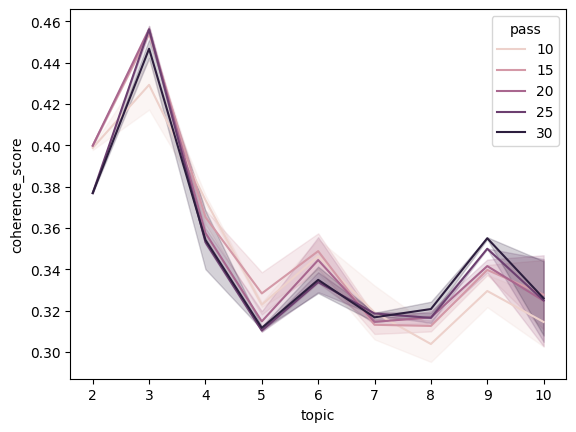

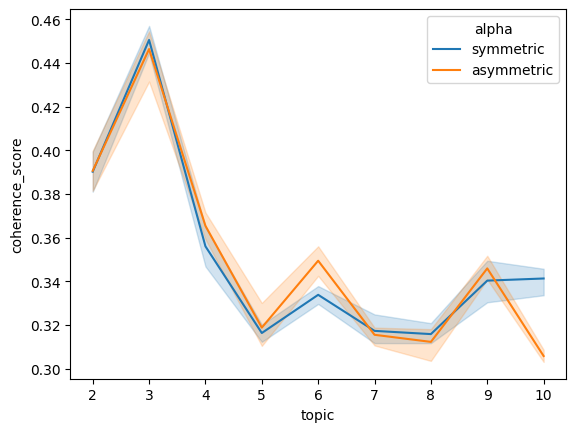

The scree plots indicate that the optimal hyperparameter configuration for maximizing the coherence score consists of 3 topics, 15 passes, and a symmetric alpha value. This configuration yields a coherence score of 0.4578.


In [40]:
# View the Scree plot to select the hyperparameters
df_scree_plot = pd.DataFrame([num_topics,passes,alphas,coherences]).T
df_scree_plot.columns = ['topic','pass','alpha','coherence_score']

sns.lineplot(data = df_scree_plot, x = 'topic', y = 'coherence_score', hue = 'pass')
plt.show()

sns.lineplot(data = df_scree_plot, x = 'topic', y = 'coherence_score', hue = 'alpha')
plt.show()

print("The scree plots indicate that the optimal hyperparameter configuration for maximizing the coherence score consists of 3 topics, 15 passes, and a symmetric alpha value. This configuration yields a coherence score of 0.4578.")

In [14]:
# Analyze the latent topics
random_state = 42
best_lda_model = LdaModel(corpus = bow_corpus, id2word = dictionary, num_topics = 3, random_state = random_state, passes = 15, alpha = "symmetric")

coherence_model_lda = CoherenceModel(model = best_lda_model, texts=job_tokens, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

for idx, topic in best_lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx + 1, topic))
    print()
    
# Observation
print('Observation:')
print('Topic 1 is associated with jobs emphasizing marketing and presentation skills, as indicated by the common terms "marketing" "grammarly" "teams" and "people"')
print('Topic 2 is linked to healthcare data science roles, marked by the notable presence of "health" and "well"')
print('Topic 3 focuses on positions rich in analytical duties, underscored by frequent mentions of "analytics" "technical" and "research"')

Topic: 1 
Words: 0.016*"marketing" + 0.014*"grammarly" + 0.009*"product" + 0.009*"teams" + 0.009*"members" + 0.007*"people" + 0.007*"best" + 0.006*"impact" + 0.006*"compensation" + 0.006*"company"

Topic: 2 
Words: 0.009*"paid" + 0.009*"employees" + 0.007*"programs" + 0.006*"support" + 0.006*"opportunities" + 0.006*"health" + 0.006*"company" + 0.006*"well" + 0.005*"total" + 0.005*"eligible"

Topic: 3 
Words: 0.005*"analytics" + 0.005*"solutions" + 0.004*"such" + 0.004*"product" + 0.004*"company" + 0.004*"technical" + 0.004*"using" + 0.004*"based" + 0.004*"insights" + 0.003*"research"

Observation:
Topic 1 is associated with jobs emphasizing marketing and presentation skills, as indicated by the common terms "marketing" "grammarly" "teams" and "people"
Topic 2 is linked to healthcare data science roles, marked by the notable presence of "health" and "well"
Topic 3 focuses on positions rich in analytical duties, underscored by frequent mentions of "analytics" "technical" and "research"


(6). Assign the topic to job description

In [15]:
# assign the topic to job description
def assign_topic(text, model, dictionary):
    token = dictionary.doc2bow(text)
    topic_distribution = model.get_document_topics(token)
    topic = str(max(topic_distribution, key=lambda x: x[1])[0])
    
    return topic

df_LDA['Job_Description_Topic'] = df_LDA['Job_Description_tokens'].apply(assign_topic, args=(best_lda_model, dictionary))
df = pd.merge(df,df_LDA,on="Job_Description",how="left")

# 5. Data Modeling

(1). Build a Transformer to process data

In [16]:
# consolidate specific skills into broader categories based on EDA and domain experience as a data science graduate student
skill_category = {}
skill_category['AI'] = ['Artificial Intelligence (AI)', 'Generative AI']
skill_category['Cloud Computing'] = ['Snowflake', 'Big Data', 'Amazon Web Services (AWS)', 'Snowflake Cloud', 'Azure Databricks', 'Amazon Redshift', 'Microsoft Azure', 'AWS SageMaker', 'Google BigQuery']
skill_category['Communication'] = ['Communication', 'Presentations', 'Data Storytelling', 'Storytelling', 'Oral Communication', 'Interpersonal Skills', 'Written Communication', 'Teamwork', 'Presentation Skills']
skill_category['Computer Science'] = ['Computer Science']
skill_category['Critical Thinking'] = ['Critical Thinking', 'Thinking Skills']
skill_category['Data Analytics'] = ['Data Analytics', 'Predictive Analytics', 'Data Analysis', 'Analytical Skills', 'Analytics', 'Statistical Data Analysis', 'Statistical Analysis', 'Quantitative Analytics', 'Exploratory Data Analysis', 'Cluster Analysis', 'Strategic Analytics', 'Big Data Analytics', 'Analytical Solutions', 'Business Process Analysis']
skill_category['Data Collection'] = ['Data Collection', 'Data Acquisition']
skill_category['Data Engineering'] = ['Data Cleaning', 'Cleansing' , 'Data Preparation', 'Data Engineering', 'Data Mining', 'Data Extraction', 'Unstructured Data', 'Data Manipulation', 'Scripting', 'Data Ingestion', 'Extract, Transform, Load (ETL)', 'Data Processing', 'Feature Selection', 'Feature Engineering', 'Data Wrangling', 'Engineering', 'Computer Engineering']
skill_category['Data Modeling'] = ['Predictive Modeling', 'Data Modeling', 'Statistical Modeling', 'Data Models', 'Model Development', 'Fine Tuning', 'Physical Data Modeling', 'Modeling', 'Linear Models', 'Structural Modeling']
skill_category['Data Visualization'] = ['Data Visualization', 'Visualization', 'Dashboards', 'Seaborn', 'Tableau', 'ggplot', 'Plotly', 'Pivot Tables']
skill_category['Database'] = ['SQL', 'Datasets', 'Open Database Connectivity (ODBC)', 'Databases', 'Relational Databases', 'Query Writing', 'Data Warehousing', 'MySQL']
skill_category['Deep Learning'] = ['TensorFlow', 'PyTorch', 'Deep Learning', 'Keras', 'Neural Networks']
skill_category['Distributed Computing'] = ['Apache Spark', 'Hive', 'PySpark', 'Hadoop', 'Distributed Computing', 'Apache NiFi']
skill_category['Experimental Design'] = ['Experimental Design']
skill_category['HTML'] = ['Cascading Style Sheets (CSS)', 'JavaScript', 'HTML']
skill_category['Kaggle'] = ['Kaggle']
skill_category['LLM'] = ['Large Language Models (LLM)', 'Language Modeling']
skill_category['Machine Learning'] = ['Machine Learning', 'Scikit-Learn', 'Machine Learning Algorithms', 'Decision Trees', 'Algorithms', 'General Linear Models', 'Lasso', 'Unsupervised Learning', 'Logistic Regression', 'Applied Machine Learning', 'Regression Models']
skill_category['Mathematics'] = ['Mathematics', 'Optimization', 'Advanced Mathematics', 'Applied Mathematics', 'Mathematical Modeling']
skill_category['Metric Development'] = ['Metric Development', 'Key Metrics']
skill_category['NLP'] = ['Natural Language Processing (NLP)']
skill_category['Other Programming Language'] = ['Java', 'Programming Languages', 'C++', '.NET Framework', 'React.js', 'Programming', 'C#', 'C (Programming Language)']
skill_category['Pattern Recognition'] = ['Pattern Recognition']
skill_category['PIV'] = ['Particle Image Velocimetry (PIV)']
skill_category['Problem Solving'] = ['Problem Solving', 'Creative Problem Solving']
skill_category['Python'] = ['Python (Programming Language)', 'NumPy', 'Pandas (Software)']
skill_category['R'] = ['R (Programming Language)', 'RStudio']
skill_category['Scala'] = ['Scala']
skill_category['Search Techniques'] = ['Semantic Search', 'Information Search', 'Operations Research']
skill_category['SEO'] = ['Search Engine Optimization (SEO)']
skill_category['Statistics'] = ['Statistics', 'Statistical Inference', 'Alpha Testing', 'Statistical Tools', 'A/B Testing', 'Forecasting', 'Hypothesis Testing', 'Time Series Analysis', 'Statistical Analysis Tools', 'Probability', 'Prediction', 'Statistical Programming','Causal Inference']

# create a inverse dictionary for retrieval
skill_category_retrieval = {}
for key,values in skill_category.items():
    for value in values:
        skill_category_retrieval[value] = key

In [17]:
# consolidate specific industries into broader categories based on EDA and common sense
industry_category = {}
industry_category["Technology & IT"] = ["Software Development","IT Services and IT Consulting","Technology, Information and Internet","Information Technology & Services","Computer Games","Internet Publishing","Computer and Network Security","Computer Networking Products"]
industry_category["Healthcare & Biotech"] = ["Biotechnology Research","Hospitals and Health Care","Pharmaceutical Manufacturing","Medical Equipment Manufacturing","Wellness and Fitness Services"]
industry_category["Financial & Business Services"] = ["Defense and Space Manufacturing","Financial Services","Banking","Business Consulting and Services","Venture Capital and Private Equity Principals","Insurance","Investment Banking"]
industry_category["Consumer Services & Retail"] = ["Consumer Services","Staffing and Recruiting","Personal Care Product Manufacturing","Apparel & Fashion","Food and Beverage Services","Retail","Retail Apparel and Fashion","Retail Luxury Goods and Jewelry","Restaurants"]
industry_category["Manufacturing & Industrial"] = ["Aviation and Aerospace Component Manufacturing","Automotive","Industrial Machinery Manufacturing","Manufacturing","Chemical Manufacturing","Semiconductor Manufacturing","Renewable Energy Equipment Manufacturing"]
industry_category["Media, Entertainment & Education"] = ["Entertainment Providers","Advertising Services","Internet Marketplace Platforms","Spectator Sports","Higher Education","Education"]
industry_category["Energy & Utilities"] = ["Utilities","Oil and Gas","Electric Power Generation"]
industry_category["Others"] = ["Legal Services","Telecommunications","Information Services","Human Resources Services","Research Services","Wholesale Building Materials","Ground Passenger Transportation","Think Tanks","Non-profit Organizations","Security and Investigations","Public Policy Offices","Professional Services","Marketing Services"]

# create a inverse dictionary for retrieval
industry_category_retrieval = {}
for key,values in industry_category.items():
    for value in values:
        industry_category_retrieval[value] = key

In [18]:
# convert job title words into position and security level based on EDA and common sense
security_words = {'Security', 'Clearance','Safety'}

job_level = {}
job_level[1] = ['Intern']
job_level[2] = ['entry', 'Entry']
job_level[3] = ['Junior','junior','Jr']
job_level[4] = ['Assistant']
job_level[5] = ['Associate']
job_level[6] = ['I']
job_level[7] = ['Intermediate']
job_level[8] = ['Mid']
job_level[9] = ['II']
job_level[10] = ['Advanced']
job_level[11] = ['III']
job_level[12] = ['Senior','Sr']
job_level[13] = ['Staff']
job_level[14] = ['Lead','Leading']
job_level[15] = ['IV']
job_level[16] = ['Direct','Director','Dir']
job_level[17] = ['VP']

# create a inverse dictionary for retrieval
job_level_retrieval = {}
for key,values in job_level.items():
    for value in values:
        job_level_retrieval[value] = key + 1 

In [19]:
# Create a Transformer
class Transformer:
    def __init__(self, df, 
                 skill_category_retrieval, 
                 industry_category_retrieval,
                 job_level_retrieval,
                 security_words):
        
        self.df = df
        self.skill_category_retrieval = skill_category_retrieval
        self.industry_category_retrieval = industry_category_retrieval
        self.job_level_retrieval = job_level_retrieval
        self.security_words = security_words
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # initialize one hot encoders
        one_hot_encoder_1 = OneHotEncoder(handle_unknown='ignore')
        one_hot_encoder_2 = OneHotEncoder(handle_unknown='ignore')
        one_hot_encoder_3 = OneHotEncoder(handle_unknown='ignore')
        
        # transform features Job_Type,Remote,Experience_Level,Company_Size,State,Job_Description_Topic
        df_part_1 = self.df[['Job_Type','Remote','Experience_Level','Company_Size','State','Job_Description_Topic']]
        one_hot_encoder_1.fit(df_part_1)
        
        X_part_1_one_hot = X[['Job_Type','Remote','Experience_Level','Company_Size','State','Job_Description_Topic']]
        X_part_1 = pd.DataFrame(one_hot_encoder_1.transform(X_part_1_one_hot[['Job_Type','Remote','Experience_Level','Company_Size','State','Job_Description_Topic']]).toarray(),columns = one_hot_encoder_1.get_feature_names_out())
        X_part_1['id'] = X_part_1_one_hot.index

        # transform features Posted_Skills & Associated_Skills
        df_part_2 = pd.DataFrame(pd.concat([self.df['Posted_Skills'].explode() , self.df['Associated_Skills'].explode()]),columns=['Skill'])
        df_part_2['Skill'] = df_part_2['Skill'].apply(lambda x: self.skill_category_retrieve(x, self.skill_category_retrieval))
        one_hot_encoder_2.fit(df_part_2)
        
        X_part_2 = pd.DataFrame(pd.concat([X['Posted_Skills'].explode() , X['Associated_Skills'].explode()]),columns=['Skill'])
        X_part_2['Skill'] = X_part_2['Skill'].apply(lambda x: self.skill_category_retrieve(x, self.skill_category_retrieval))
        X_part_2['id'] = X_part_2.index

        X_part_2_one_hot = pd.DataFrame(one_hot_encoder_2.transform(X_part_2[['Skill']]).toarray(),columns = one_hot_encoder_2.get_feature_names_out())
        X_part_2_one_hot['id'] = X_part_2.index
        X_part_2 = X_part_2_one_hot.groupby("id").sum()
        X_part_2 = X_part_2.reset_index()
        
        # transform feature Field
        df_part_3 = self.df[['Field']]
        df_part_3['Field'] = df_part_3['Field'].apply(lambda x: self.industry_category_retrieve(x, self.industry_category_retrieval)).fillna('Others')
        one_hot_encoder_3.fit(df_part_3)
        
        X_part_3_one_hot = X[['Field']]
        X_part_3_one_hot['Field'] = X_part_3_one_hot['Field'].apply(lambda x: self.industry_category_retrieve(x, self.industry_category_retrieval))

        X_part_3 = pd.DataFrame(one_hot_encoder_3.transform(X_part_3_one_hot).toarray(),columns = one_hot_encoder_3.get_feature_names_out())
        X_part_3['id'] = X_part_3_one_hot.index

        # transform feature Job_Level
        X_part_4 = pd.DataFrame(X['Job_Title_Words'].explode())
        X_part_4.columns = ['Job_Level']
        X_part_4['Job_Level'] = X_part_4['Job_Level'].apply(lambda x: self.job_level_retrieve(x, self.job_level_retrieval)).fillna(0)
        X_part_4['id'] = X_part_4.index
        X_part_4 = X_part_4.groupby('id').max().reset_index()
        
        # transform feature Security_level
        X_part_5 = X[['Job_Title_Words']]
        X_part_5.columns = ['Security_level']
        X_part_5['Security_level'] = X_part_5['Security_level'].apply(self.security_level_retrieve)
        X_part_5['id'] = X_part_5.index
        
        X = X_part_1.merge(X_part_2, on = 'id', how='inner').merge(X_part_3, on = 'id', how='inner').merge(X_part_4, on = 'id', how='inner').merge(X_part_5, on = 'id', how='inner')
        # X = X.drop('id',axis = 1)
        
        return X

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)
    
    def skill_category_retrieve(self, value, dictionary):
        return dictionary.get(value, None)

    def industry_category_retrieve(self, value, dictionary):
        return dictionary.get(value, None)

    def job_level_retrieve(self, value, dictionary):
        return dictionary.get(value, None)

    def security_level_retrieve(self, value):
        value_set = set(value)
        security_words = self.security_words
        intersect = value_set & security_words
        if intersect:
            return 1
        else:
            return 0

In [20]:
# create the transformer to preprocess data set
transformer = Transformer(df, skill_category_retrieval, industry_category_retrieval, job_level_retrieval, security_words)

(2). Create training and testing sets.

In [21]:
# split the training and testing set
X_train, X_test, y_train, y_test = train_test_split(df,df[['Salary_Lower','Salary_Upper']], test_size = 0.3, random_state = random_state, )

# split target data for Salary Lower Bound & Upper Bound
y_train_upper = y_train['Salary_Upper']
y_test_upper = y_test['Salary_Upper']
y_train_lower = y_train['Salary_Lower']
y_test_lower = y_test['Salary_Lower']

(3). Model Training and Fine-tuning for Salary Lower Bound & Upper Bound

In [22]:
# XGBoost - Lower Bound
param = {
        'xgb__n_estimators': [100, 150, 200], 
        'xgb__learning_rate': [0.05, 0.08, 0.10],  
        'xgb__max_depth': [6, 8, 10],
        'xgb__reg_alpha' :[10, 50, 100],
        'xgb__reg_lambda':[20, 30, 50 ],
        'xgb__random_state': [random_state]
        }

cv = KFold(n_splits=3, shuffle=True, random_state = random_state)
xgb_pipe_lower = Pipeline(
            steps=[
            ('transform', transformer),
            ('xgb', XGBRegressor())])

xgb_cv_lower = GridSearchCV(xgb_pipe_lower, param_grid = param, cv=cv, scoring="r2")
xgb_cv_lower.fit(X_train,y_train_lower)

print("Best parameter for XGBoost:", xgb_cv_lower.best_params_)

# derive the predicted outcomes
y_train_pred_xgb_lower = xgb_cv_lower.predict(X_train)
y_test_pred_xgb_lower = xgb_cv_lower.predict(X_test)

train_rmse = mean_squared_error(y_train_lower, y_train_pred_xgb_lower, squared=False)
train_r2 = r2_score(y_train_lower, y_train_pred_xgb_lower)

test_rmse = mean_squared_error(y_test_lower, y_test_pred_xgb_lower, squared=False)
test_r2 = r2_score(y_test_lower, y_test_pred_xgb_lower)

print(f"Salary Lower Bound: XGBoost RMSE for training set: {train_rmse}")
print(f"Salary Lower Bound: XGBoost R^2 for training set: {train_r2*100:.2f}%")
print(f"Salary Lower Bound: XGBoost RMSE for testing set: {test_rmse}")
print(f"Salary Lower Bound: XGBoost R^2 for testing set: {test_r2*100:.2f}%")

Best parameter for XGBoost: {'xgb__learning_rate': 0.08, 'xgb__max_depth': 6, 'xgb__n_estimators': 200, 'xgb__random_state': 42, 'xgb__reg_alpha': 100, 'xgb__reg_lambda': 50}
Salary Lower Bound: XGBoost RMSE for training set: 9102.22790827065
Salary Lower Bound: XGBoost R^2 for training set: 95.38%
Salary Lower Bound: XGBoost RMSE for testing set: 19880.389279042574
Salary Lower Bound: XGBoost R^2 for testing set: 75.32%


In [23]:
# XGBoost - Upper Bound
param = {
        'xgb__n_estimators': [100, 120, 150], 
        'xgb__learning_rate': [0.05, 0.07 ,0.10],  
        'xgb__max_depth': [3, 5, 8],
        'xgb__reg_alpha' :[0.05, 0.1, 0.15],
        'xgb__reg_lambda':[0.01, 0.1, 1],
        'xgb__random_state': [random_state]
        }

cv = KFold(n_splits=3, shuffle=True, random_state = random_state)
xgb_pipe_upper = Pipeline(
            steps=[
            ('transform', transformer),
            ('xgb', XGBRegressor())])

xgb_cv_upper = GridSearchCV(xgb_pipe_upper, param_grid = param, cv=cv, scoring="r2")
xgb_cv_upper.fit(X_train,y_train_upper)

print("Best parameter for XGBoost:", xgb_cv_upper.best_params_)

# derive the predicted outcomes
y_train_pred_xgb_upper = xgb_cv_upper.predict(X_train)
y_test_pred_xgb_upper = xgb_cv_upper.predict(X_test)

train_rmse = mean_squared_error(y_train_upper, y_train_pred_xgb_upper, squared=False)
train_r2 = r2_score(y_train_upper, y_train_pred_xgb_upper)

test_rmse = mean_squared_error(y_test_upper, y_test_pred_xgb_upper, squared=False)
test_r2 = r2_score(y_test_upper, y_test_pred_xgb_upper)

print(f"Salary Upper Bound: XGBoost RMSE for training set: {train_rmse}")
print(f"Salary Upper Bound: XGBoost R^2 for training set: {train_r2 * 100:.2f}%")
print(f"Salary Upper Bound: XGBoost RMSE for testing set: {test_rmse}")
print(f"Salary Upper Bound: XGBoost R^2 for testing set: {test_r2 * 100:.2f}%")

Best parameter for XGBoost: {'xgb__learning_rate': 0.05, 'xgb__max_depth': 5, 'xgb__n_estimators': 120, 'xgb__random_state': 42, 'xgb__reg_alpha': 0.15, 'xgb__reg_lambda': 0.1}
Salary Upper Bound: XGBoost RMSE for training set: 17924.145610025884
Salary Upper Bound: XGBoost R^2 for training set: 93.19%
Salary Upper Bound: XGBoost RMSE for testing set: 30850.4016123647
Salary Upper Bound: XGBoost R^2 for testing set: 72.05%


In [24]:
# Random Forest
param = {
        'rf__n_estimators': [30,40,50 ],     
        'rf__max_depth': [10,11,12],  
        'rf__max_features': [60,70,80],
        'rf__min_samples_leaf': [7,8,9],
        'rf__random_state': [random_state]
        }

cv = KFold(n_splits=3, shuffle=True, random_state = random_state)

rf_pipe_lower = Pipeline(
            steps=[
            ('transform', transformer),
            ('rf', RandomForestRegressor())])

rf_cv_lower = GridSearchCV(rf_pipe_lower, param_grid = param, cv=cv, scoring="r2")
rf_cv_lower.fit(X_train,y_train_lower)

print("Best parameter for Random Forest:", rf_cv_lower.best_params_)

# derive the predicted outcomes
y_train_pred_rf_lower = rf_cv_lower.predict(X_train)
y_test_pred_rf_lower = rf_cv_lower.predict(X_test)

train_rmse = mean_squared_error(y_train_lower, y_train_pred_rf_lower, squared=False)
train_r2 = r2_score(y_train_lower, y_train_pred_rf_lower)

test_rmse = mean_squared_error(y_test_lower, y_test_pred_rf_lower, squared=False)
test_r2 = r2_score(y_test_lower, y_test_pred_rf_lower)

print(f"Salary Lower Bound: Random Forest RMSE for training set: {train_rmse}")
print(f"Salary Lower Bound: Random Forest R^2 for training set: {train_r2*100:.2f}%")
print(f"Salary Lower Bound: Random Forest RMSE for testing set: {test_rmse}")
print(f"Salary Lower Bound: Random Forest R^2 for testing set: {test_r2*100:.2f}%")

Best parameter for Random Forest: {'rf__max_depth': 11, 'rf__max_features': 80, 'rf__min_samples_leaf': 7, 'rf__n_estimators': 30, 'rf__random_state': 42}
Salary Lower Bound: Random Forest RMSE for training set: 18175.52957756869
Salary Lower Bound: Random Forest R^2 for training set: 81.58%
Salary Lower Bound: Random Forest RMSE for testing set: 19929.62380500636
Salary Lower Bound: Random Forest R^2 for testing set: 75.20%


In [25]:
# Random Forest
param = {
        'rf__n_estimators': [30,40,50 ],     
        'rf__max_depth': [10,11,12],  
        'rf__max_features': [60,70,80],
        'rf__min_samples_leaf': [7,8,9],
        'rf__random_state': [random_state]
        }

cv = KFold(n_splits=3, shuffle=True, random_state = random_state)

rf_pipe_upper = Pipeline(
            steps=[
            ('transform', transformer),
            ('rf', RandomForestRegressor())])

rf_cv_upper = GridSearchCV(rf_pipe_upper, param_grid = param, cv=cv, scoring="r2")
rf_cv_upper.fit(X_train,y_train_upper)

print("Best parameter for Random Forest:", rf_cv_upper.best_params_)

# derive the predicted outcomes
y_train_pred_rf_upper = rf_cv_upper.predict(X_train)
y_test_pred_rf_upper = rf_cv_upper.predict(X_test)

train_rmse = mean_squared_error(y_train_upper, y_train_pred_rf_upper, squared=False)
train_r2 = r2_score(y_train_upper, y_train_pred_rf_upper)

test_rmse = mean_squared_error(y_test_upper, y_test_pred_rf_upper, squared=False)
test_r2 = r2_score(y_test_upper, y_test_pred_rf_upper)

print(f"Salary Upper Bound: Random Forest RMSE for training set: {train_rmse}")
print(f"Salary Upper Bound: Random Forest R^2 for training set: {train_r2*100:.2f}%")
print(f"Salary Upper Bound: Random Forest RMSE for testing set: {test_rmse}")
print(f"Salary Upper Bound: Random Forest R^2 for testing set: {test_r2*100:.2f}%")

Best parameter for Random Forest: {'rf__max_depth': 11, 'rf__max_features': 60, 'rf__min_samples_leaf': 7, 'rf__n_estimators': 40, 'rf__random_state': 42}
Salary Upper Bound: Random Forest RMSE for training set: 36146.74653292382
Salary Upper Bound: Random Forest R^2 for training set: 72.29%
Salary Upper Bound: Random Forest RMSE for testing set: 31934.5915329061
Salary Upper Bound: Random Forest R^2 for testing set: 70.05%


In [26]:
# choose the final model
final_model_salary_lower = xgb_cv_lower
final_model_salary_upper = xgb_cv_lower

In [27]:
final_model_salary_lower

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('transform',
                                        <__main__.Transformer object at 0x0000022DE57F0690>),
                                       ('xgb',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=Non...
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None,
                                                     reg_alpha=None,
                                                     reg_lambda=None, ...))]),
             param_grid={'xgb__learning_rate': [0.05, 0.08, 0.1],
                         'xgb__max_depth': [6, 8, 10],
                         'xgb__n_estimators': [100, 150, 200],
                         'xgb__random_state': [42],
                         'xgb__reg_alpha': [10, 50, 100],
                         'xgb__reg_lambda': [20, 30, 50]},
             scoring='r2')

In [28]:
final_model_salary_upper

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('transform',
                                        <__main__.Transformer object at 0x0000022DE57F0690>),
                                       ('xgb',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=Non...
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None,
                                                     reg_alpha=None,
                                                     reg_lambda=None, ...))]),
             param_grid={'xgb__learning_rate': [0.05, 0.08, 0.1],
                         'xgb__max_depth': [6, 8, 10],
                         'xgb__n_estimators': [100, 150, 200],
                         'xgb__random_state': [42],
                         'xgb__reg_alpha': [10, 50, 100],
                         'xgb__reg_lambda': [20, 30, 50]},
             scoring='r2')